<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3: Generative Adversarial Networks
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [ ]:
Name = "fariborz kohanzad"
StudentId = "400103613"

### In this notebook, you will implement the required components from scratch, without code completion. Utilize `torch` to create models and perform optimization. The goal of this assignment is to implement Deep Convolutional Generative Adversarial Networks (DC-GAN) using the MNIST dataset and to explore interpolation in the latent space.

### To get started, please read the DC-GAN paper available at this link: [DC-GAN Paper](https://arxiv.org/abs/1511.06434v2).


### Part 1. Load the MNIST dataset.

In [25]:
import torch
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import yaml
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import random

In [3]:
# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
def load_mnist(batch_size=128):
    # Training dataset
    train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )

    # Testing dataset
    test_dataset = datasets.MNIST(
        root='./data',
        train=False,
        transform=transform,
        download=True
    )

    # DataLoader for batching
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, test_loader

train_loader, test_loader = load_mnist()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in test set: {len(test_loader)}")

Number of batches in training set: 469
Number of batches in test set: 79


### Part 2: Build the Generator and Discriminator models.
Build the models with the architecture guidelines for stable training as described in the paper. It is recommended to use the model parameters presented in `config.yaml`, but you are free to choose any set of parameters you prefer.


In [6]:
# Load configuration
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

model_params = config["model_params"]

# Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim, channels, kernels, strides, paddings, output_paddings):
        super(Generator, self).__init__()
        layers = []
        in_channels = latent_dim

        # Build the generator layers dynamically
        for i in range(len(channels)):
            layers.append(
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=channels[i],
                    kernel_size=kernels[i],
                    stride=strides[i],
                    padding=paddings[i],
                    output_padding=output_paddings[i],
                    bias=False,
                )
            )
            layers.append(nn.BatchNorm2d(channels[i]))
            layers.append(nn.ReLU(inplace=True))
            in_channels = channels[i]

        # Final layer to output the image
        layers.append(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=1,
                kernel_size=kernels[-1],
                stride=strides[-1],
                padding=paddings[-1],
                bias=False,
            )
        )
        layers.append(nn.Tanh())

        self.model = nn.Sequential(*layers)

    def forward(self, z):
        z = z.view(z.size(0), -1, 1, 1)
        return self.model(z)


# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, channels, kernels, strides, paddings):
        super(Discriminator, self).__init__()
        layers = []
        in_channels = 1

        # Build the discriminator layers dynamically
        for i in range(len(channels)):
            layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=channels[i],
                    kernel_size=kernels[i],
                    stride=strides[i],
                    padding=paddings[i],
                    bias=False,
                )
            )
            if i > 0:  # Apply batch normalization to all layers except the first
                layers.append(nn.BatchNorm2d(channels[i]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            in_channels = channels[i]

        # Final layer for classification
        layers.append(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=1,
                kernel_size=kernels[-1],
                stride=strides[-1],
                padding=paddings[-1],
                bias=False,
            )
        )
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img).view(-1)


# Instantiate the models using the configuration
latent_dim = model_params["latent_dim"]
generator_channels = model_params["generator_channels"]
generator_kernels = model_params["generator_kernels"]
generator_strides = model_params["generator_strides"]
generator_paddings = model_params["generator_paddings"]
generator_output_paddings = model_params["generator_output_paddings"]

discriminator_channels = model_params["discriminator_channels"]
discriminator_kernels = model_params["discriminator_kernels"]
discriminator_strides = model_params["discriminator_strides"]
discriminator_paddings = model_params["discriminator_paddings"]

generator = Generator(
    latent_dim,
    generator_channels,
    generator_kernels,
    generator_strides,
    generator_paddings,
    generator_output_paddings,
)

discriminator = Discriminator(
    discriminator_channels,
    discriminator_kernels,
    discriminator_strides,
    discriminator_paddings,
)

# Print model architectures
print("Generator:")
print(generator)

print("\nDiscriminator:")
print(discriminator)


Generator:
Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

Discriminator:
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

### Part 3: Write a function to train the models using the GAN framework.
You can refer to the slides or the original GAN paper for the training schema: [GAN Paper](https://arxiv.org/abs/1406.2661). Additionally, create a function to generate samples from the model. Ensure to plot a grid of generated samples every n'th epoch.


In [9]:
def train_gan(generator, discriminator, dataloader, config, epochs=50, sample_interval=5, device="cuda"):
    """
    Train the GAN models.

    Args:
        generator (nn.Module): Generator model.
        discriminator (nn.Module): Discriminator model.
        dataloader (DataLoader): DataLoader for the training data.
        config (dict): Configuration dictionary.
        epochs (int): Number of training epochs.
        sample_interval (int): Interval for generating and displaying samples.
        device (str): Device to train on ("cuda" or "cpu").

    Returns:
        None
    """
    # Load configuration parameters
    latent_dim = config["model_params"]["latent_dim"]

    # Loss function and optimizers
    adversarial_loss = torch.nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Move models to the selected device
    generator.to(device)
    discriminator.to(device)

    # Training loop
    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(dataloader):
            # Ground truths
            valid = torch.ones((imgs.size(0), ), device=device)
            fake = torch.zeros((imgs.size(0), ), device=device)

            # Real images
            real_imgs = imgs.to(device)

            # ---------------------
            # Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Generate fake images
            z = torch.randn((imgs.size(0), latent_dim), device=device)
            gen_imgs = generator(z)

            # Discriminator loss
            real_loss = adversarial_loss(discriminator(real_imgs).view(-1), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()).view(-1), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # -----------------
            # Train Generator
            # -----------------
            optimizer_G.zero_grad()

            # Generate fake images
            g_loss = adversarial_loss(discriminator(gen_imgs).view(-1), valid)

            g_loss.backward()
            optimizer_G.step()

        # Print training progress
        print(f"Epoch {epoch + 1}/{epochs} | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")



def generate_samples(generator , num_samples , device="cuda"):
    """
    Generate and plot samples from the generator.

    Args:
        generator (nn.Module): Generator model.
        latent_dim (int): Latent dimension size.
        epoch (int): Current epoch number.
        device (str): Device to use for inference.
        num_samples (int): Number of samples to generate.

    Returns:
        None
    """
    latent_dim = config["model_params"]["latent_dim"]

    generator.eval()

    # Generate latent space inputs
    z = torch.randn((num_samples, latent_dim), device=device)

    # Generate images
    gen_imgs = generator(z).cpu().detach().numpy()
    gen_imgs = (gen_imgs + 1) / 2.0

    # Plot generated images
    fig, axs = plt.subplots(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), figsize=(10, 10))
    cnt = 0
    for i in range(int(np.sqrt(num_samples))):
        for j in range(int(np.sqrt(num_samples))):
            axs[i, j].imshow(gen_imgs[cnt, 0, :, :], cmap="gray")
            axs[i, j].axis("off")
            cnt += 1
    plt.suptitle("Generated Sampels")
    plt.show()

### Part 4: Plot a grid of 100 generated samples.

In [10]:
train_gan(generator, discriminator, train_loader, config)

Epoch 1/50 | D Loss: 0.5031041502952576 | G Loss: 1.7760779857635498
Epoch 2/50 | D Loss: 0.47656914591789246 | G Loss: 1.02799654006958
Epoch 3/50 | D Loss: 0.24020256102085114 | G Loss: 2.343658208847046
Epoch 4/50 | D Loss: 0.2742294371128082 | G Loss: 2.915325164794922
Epoch 5/50 | D Loss: 0.23784911632537842 | G Loss: 3.0075583457946777
Epoch 6/50 | D Loss: 0.24887308478355408 | G Loss: 1.7577321529388428
Epoch 7/50 | D Loss: 0.2490440458059311 | G Loss: 3.6756458282470703
Epoch 8/50 | D Loss: 0.18379074335098267 | G Loss: 2.9593591690063477
Epoch 9/50 | D Loss: 0.1945372372865677 | G Loss: 3.4953906536102295
Epoch 10/50 | D Loss: 0.1689874231815338 | G Loss: 2.7120532989501953
Epoch 11/50 | D Loss: 0.20935852825641632 | G Loss: 1.8650548458099365
Epoch 12/50 | D Loss: 0.1887854039669037 | G Loss: 3.1974284648895264
Epoch 13/50 | D Loss: 0.382591187953949 | G Loss: 5.6252288818359375
Epoch 14/50 | D Loss: 0.1611909568309784 | G Loss: 4.282660961151123
Epoch 15/50 | D Loss: 0.22871

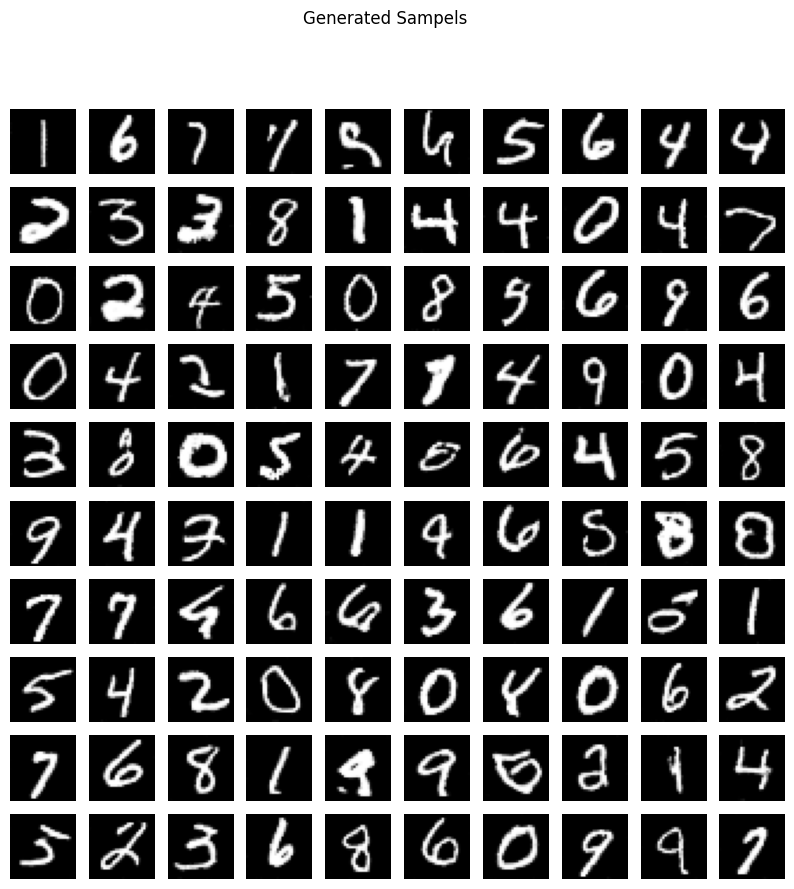

In [11]:
generate_samples(generator , num_samples=100)

### Part 5: GAN Inversion
In this part, we aim to find the latent vectors corresponding to the samples in the dataset. First, select a random sample from the real dataset and a random latent vector. Freeze the generator and feed the random latent vector into the Generator. Next, define an MSE or MAE loss between the generated sample and the real sample, and optimize the random latent vector to discover the latent vector that generates the selected real sample.


Step 499/500, Loss: 0.0052


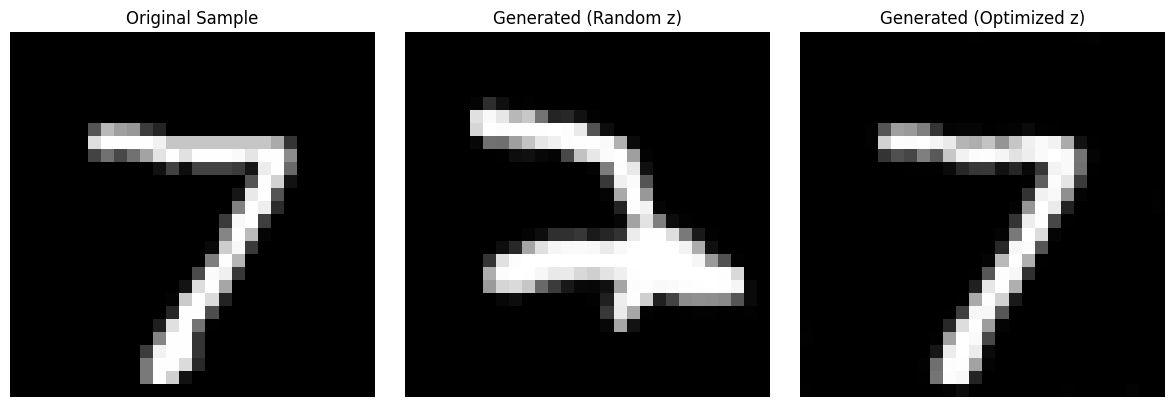

In [17]:
def find_latent_vector_and_compare(generator, real_sample, latent_dim, steps=500, lr=0.01, loss_fn="mse", device="cuda"):
    """
    Optimize a latent vector to find the one that generates a given real sample and compare with the original random z.

    Args:
        generator (nn.Module): Trained generator model.
        real_sample (torch.Tensor): Real sample to match (1, C, H, W).
        latent_dim (int): Dimension of the latent space.
        steps (int): Number of optimization steps.
        lr (float): Learning rate for optimization.
        loss_fn (str): Loss function, either 'mse' or 'mae'.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        optimized_z (torch.Tensor): Latent vector corresponding to the real sample.
    """
    generator.eval()
    real_sample = real_sample.to(device)

    # Initialize a random latent vector
    z_random = torch.randn((1, latent_dim), device=device)
    z = z_random.clone().detach().requires_grad_(True)

    # Generate sample from the random z
    gen_sample_from_random_z = generator(z_random).detach().cpu()

    optimizer = torch.optim.Adam([z], lr=lr)

    if loss_fn == "mse":
        criterion = torch.nn.MSELoss()
    elif loss_fn == "mae":
        criterion = torch.nn.L1Loss()
    else:
        raise ValueError("loss_fn must be either 'mse' or 'mae'")

    # Optimization loop
    for step in range(steps):
        optimizer.zero_grad()

        # Generate sample from latent vector
        gen_sample = generator(z).squeeze(0)  # Remove batch dimension

        # Compute loss
        loss = criterion(gen_sample, real_sample)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        if step == steps - 1:
            print(f"Step {step}/{steps}, Loss: {loss.item():.4f}")

    # Generate the optimized sample
    gen_sample_from_optimized_z = generator(z).detach().cpu()

    # Plot the images
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(real_sample.squeeze().cpu().numpy(), cmap="gray")
    axs[0].set_title("Original Sample")
    axs[0].axis("off")

    axs[1].imshow(gen_sample_from_random_z.squeeze().numpy(), cmap="gray")
    axs[1].set_title("Generated (Random z)")
    axs[1].axis("off")

    axs[2].imshow(gen_sample_from_optimized_z.squeeze().numpy(), cmap="gray")
    axs[2].set_title("Generated (Optimized z)")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

    return z.detach()



# Randomly select a real sample
real_sample, _ = next(iter(test_loader))
real_sample = real_sample[0:1]

# Discover and compare the latent vector
latent_vector = find_latent_vector_and_compare(generator, real_sample, latent_dim=config["model_params"]["latent_dim"], steps=500, lr=0.01)


### Part 6: Interpolating the Latent Space
In this part, you will interpolate the latent space using a 10 by 10 grid. Start with 4 initial points representing the corners of the square, and then perform linear or spherical interpolation between the latent vectors of these 4 images to fill the circumference of the square.
Next, fill in the rest of the square by interpolating between the latent vectors along the circumference.

If $G$ is the generator, and $z_1$ and $z_2$ are two latent vectors of two images, let $w$ be a parameter that varies between $0$ and $1$. The linearly interpolated sample is generated as:

\begin{equation}
G(w \cdot z_1 + (1 - w) \cdot z_2)\
\end{equation}

Try to select the 4 starting images from those that exhibit distinct features. For example, the two top right corners could be the same digit but one with a thick stroke and the other with a thin stroke, while the other two points should be from a different digit but with varying stroke styles.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


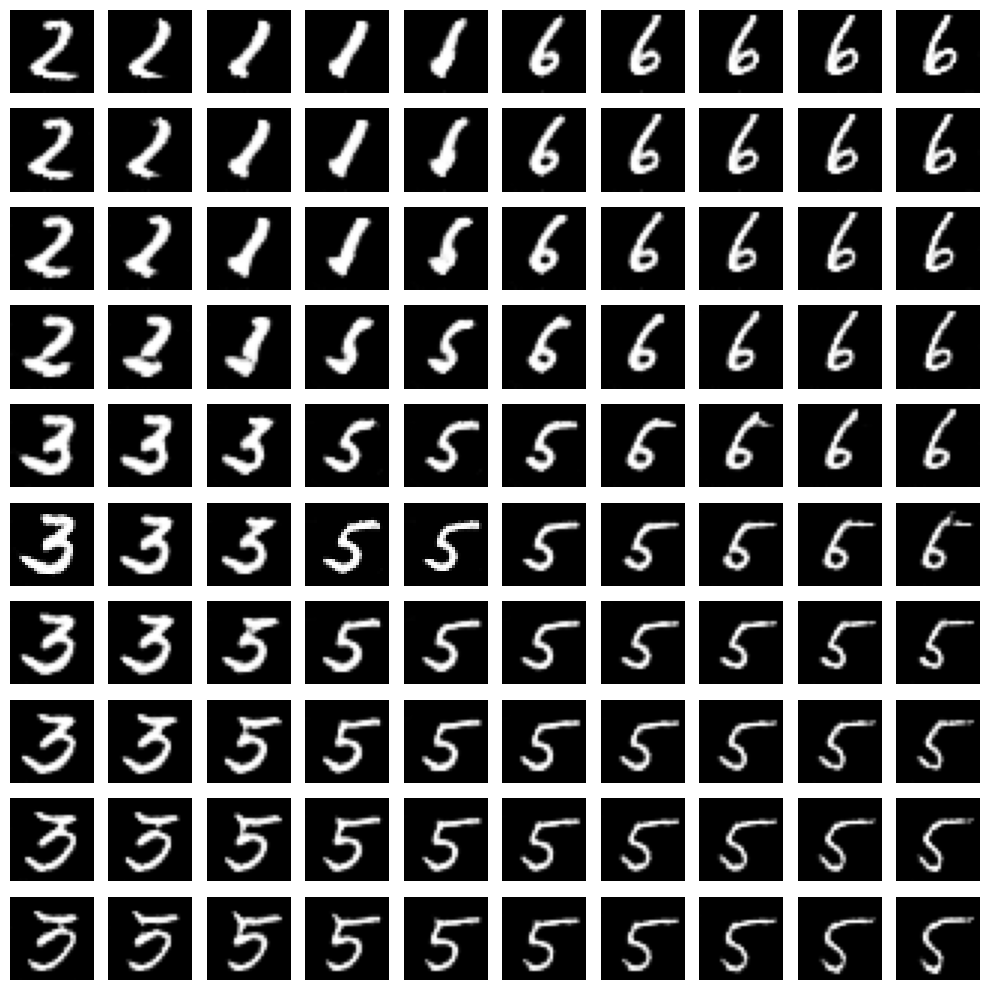

In [106]:
def find_latent_vector(generator, real_sample, latent_dim, steps=500, lr=0.01, loss_fn="mse", device="cuda"):
    """
    Optimize a latent vector to find the one that generates a given real sample.

    Args:
        generator (nn.Module): Trained generator model.
        real_sample (torch.Tensor): Real sample to match (1, C, H, W).
        latent_dim (int): Dimension of the latent space.
        steps (int): Number of optimization steps.
        lr (float): Learning rate for optimization.
        loss_fn (str): Loss function, either 'mse' or 'mae'.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        optimized_z (torch.Tensor): Latent vector corresponding to the real sample.
    """
    generator.eval()
    real_sample = real_sample.to(device)

    # Initialize a random latent vector
    z = torch.randn((1, latent_dim), device=device, requires_grad=True)

    # Define optimizer
    optimizer = torch.optim.Adam([z], lr=lr)

    # Define loss function
    if loss_fn == "mse":
        criterion = torch.nn.MSELoss()
    elif loss_fn == "mae":
        criterion = torch.nn.L1Loss()
    else:
        raise ValueError("loss_fn must be either 'mse' or 'mae'")

    # Optimization loop
    for step in range(steps):
        optimizer.zero_grad()

        # Generate sample from latent vector
        gen_sample = generator(z).squeeze(0)

        # Compute loss
        loss = criterion(gen_sample, real_sample)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        #if step == steps - 1:
        #    print(f"Step {step}/{steps}, Loss: {loss.item():.4f}")

    return z.detach()

def interpolate_latent_space(generator, latent_dim, corner_latents, grid_size=10, device="cuda"):
    """
    Interpolate the latent space using a 10x10 grid.

    Args:
        generator (nn.Module): Trained generator model.
        latent_dim (int): Dimension of the latent space.
        corner_latents (list of torch.Tensor): List of 4 latent vectors for the corners.
        grid_size (int): Size of the grid (default: 10).
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        grid_images (torch.Tensor): Generated images for the grid.
    """
    generator.eval()

    assert len(corner_latents) == 4, "Exactly 4 corner latent vectors are required."

    # Interpolation weights
    weights = torch.linspace(0, 1, grid_size, device=device)

    # Grid of latent vectors
    grid_latents = []
    for i in range(grid_size):
        # Interpolate between top-left and top-right
        top_row = weights[i] * corner_latents[1] + (1 - weights[i]) * corner_latents[0]
        # Interpolate between bottom-left and bottom-right
        bottom_row = weights[i] * corner_latents[3] + (1 - weights[i]) * corner_latents[2]
        # Interpolate along each column
        for j in range(grid_size):
            interpolated_latent = weights[j] * bottom_row + (1 - weights[j]) * top_row
            grid_latents.append(interpolated_latent)

    grid_latents = torch.stack(grid_latents).to(device)

    # Generate images from the interpolated latent vectors
    with torch.no_grad():
        grid_images = generator(grid_latents).detach().cpu()

    return grid_images


def plot_interpolation_grid(grid_images, grid_size=10):
    """
    Plot the generated images in a grid.

    Args:
        grid_images (torch.Tensor): Generated images for the grid (C, H, W).
        grid_size (int): Size of the grid.

    Returns:
        None
    """
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    cnt = 0
    for i in range(grid_size):
        for j in range(grid_size):
            axs[i, j].imshow(grid_images[cnt].squeeze(), cmap="gray")
            axs[i, j].axis("off")
            cnt += 1
    plt.tight_layout()
    plt.show()



# Select 4 distinct corner latents
real_samples, _ = next(iter(train_loader))
real_samples = real_samples[:4].to("cuda")

# Discover latent vectors for the selected real samples
corner_latents = [
    find_latent_vector(generator, real_sample.unsqueeze(0), latent_dim=config["model_params"]["latent_dim"], steps=200)
    for real_sample in real_samples
]

# Interpolate the latent space
grid_images = interpolate_latent_space(generator, latent_dim=config["model_params"]["latent_dim"], corner_latents=corner_latents)

# Plot the interpolation grid
plot_interpolation_grid(grid_images)


### Part 7: Arithmetic Operation in Latent Space
In this part, you will attempt to modify the thickness or thinness of a sample by identifying the direction in the latent space that corresponds to these attributes. Additionally, you can explore changing a digit to another (e.g., transforming a digit into a 3) by finding the direction in the latent space that corresponds to that digit.


In [107]:
def display_batch(batch , num_samples ,title , labels=None):
    """
    Display a grid of training data images from a batch.

    Args:
        batch (torch.Tensor): A batch of training data (N, C, H, W).
        labels (torch.Tensor): Corresponding labels for the data (optional).
        num_samples (int): Number of samples to display.

    Returns:
        None
    """
    # Limit to the specified number of samples
    num_samples = min(num_samples, len(batch))
    images = batch[:num_samples]

    # Calculate grid size
    grid_size = int(num_samples**0.5)
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for idx, ax in enumerate(axs.flat):
        if idx < num_samples:
            image = images[idx].squeeze().cpu().numpy()
            ax.imshow(image, cmap="gray")
            if labels is not None:
                ax.set_title(f"Label: {labels[idx].item()}")
            ax.axis("off")
        else:
            ax.axis("off")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [111]:
def get_thick_and_thin_samples(dataloader, num_samples=50, num_thick=10, num_thin=10):
    """
    Get thick and thin samples across all labels in the dataset based on pixel intensity sums.

    Args:
        dataloader (DataLoader): DataLoader for the dataset.
        num_samples (int): Number of images to load for each label.
        num_thick (int): Number of thick images to return for each label.
        num_thin (int): Number of thin images to return for each label.

    Returns:
        tuple: Two lists containing all thick samples and all thin samples, respectively.
    """
    # Initialize data structures
    label_counts = {label: 0 for label in range(10)}
    selected_images = {label: [] for label in range(10)}

    # Collect images for each label
    for images, labels in dataloader:
        for img, lbl in zip(images, labels):
            lbl = lbl.item()
            if label_counts[lbl] < num_samples:
                selected_images[lbl].append(img)
                label_counts[lbl] += 1
            if all(count >= num_samples for count in label_counts.values()):
                break
        if all(count >= num_samples for count in label_counts.values()):
            break

    thick_samples = []
    thin_samples = []

    for label in range(10):
        # Calculate pixel sums
        pixel_sums = [img.sum().item() for img in selected_images[label]]

        # Sort by pixel sum
        sorted_indices = sorted(range(len(pixel_sums)), key=lambda i: pixel_sums[i])

        thin_samples.extend([selected_images[label][i] for i in sorted_indices[:num_thin]])
        thick_samples.extend([selected_images[label][i] for i in sorted_indices[-num_thick:]])

    return thick_samples, thin_samples

100


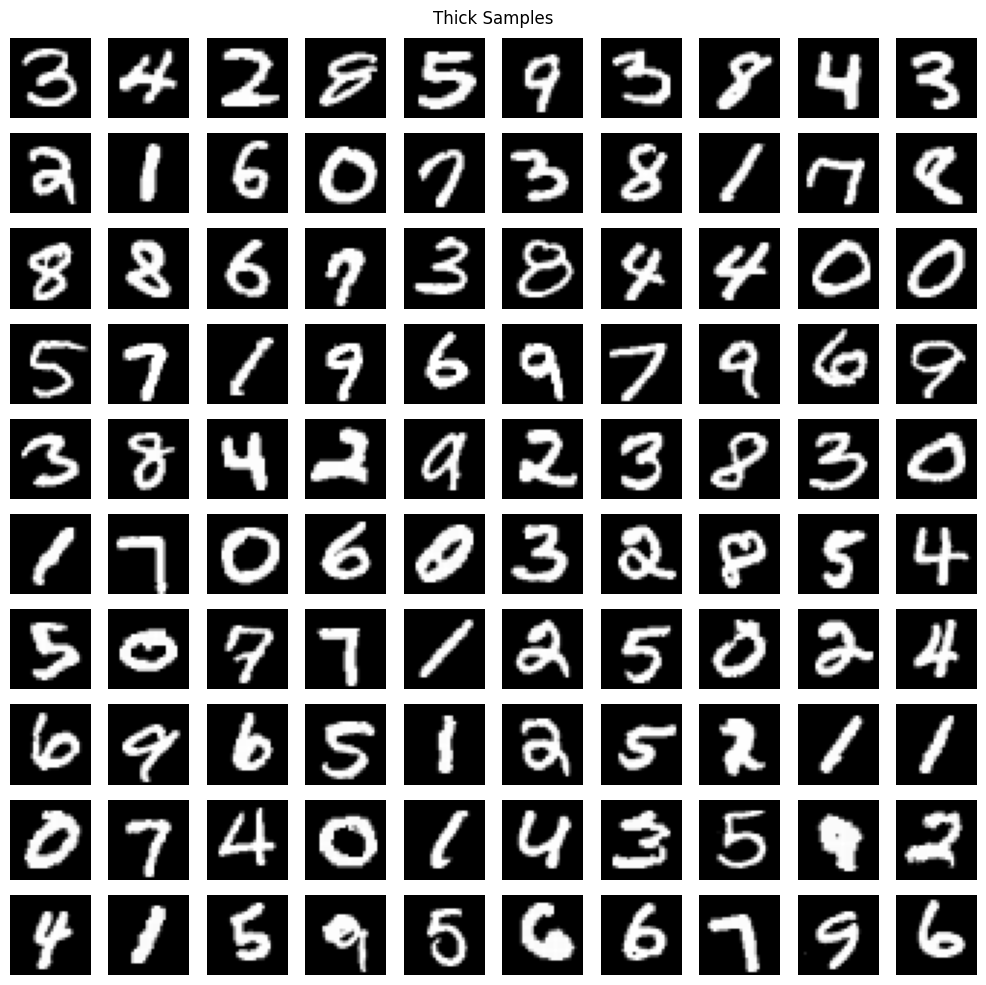

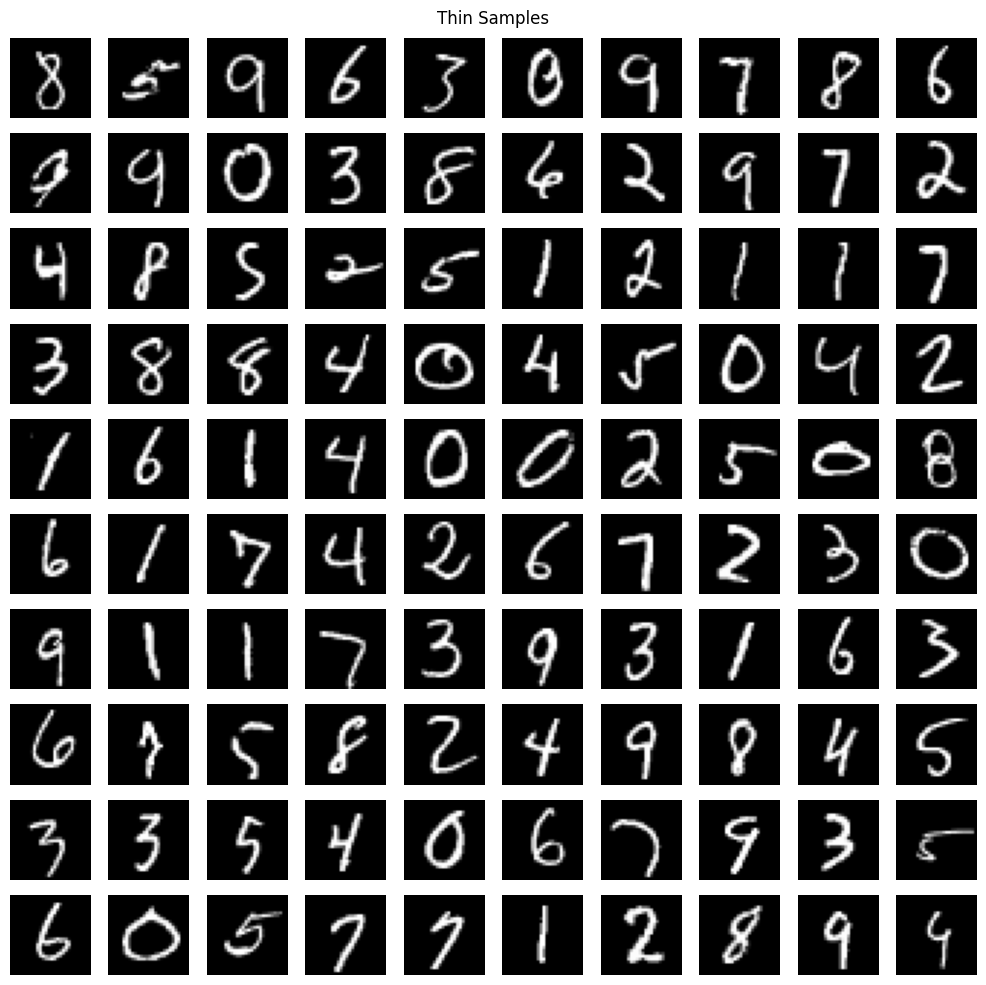

In [112]:
thick_samples, thin_samples = get_thick_and_thin_samples(train_loader)
print(len(thick_samples))
random.shuffle(thick_samples)
random.shuffle(thin_samples)

display_batch(thick_samples, num_samples=100 , title ="Thick Samples")
display_batch(thin_samples, num_samples=100 , title ="Thin Samples")

In [113]:
def identify_direction(generator, target_samples, source_samples, latent_dim, steps=200, device="cuda"):
    """
    Identify the latent space direction corresponding to thickness or thinness.

    Args:
        generator (nn.Module): Trained generator model.
        thick_samples (torch.Tensor): Real samples representing thick strokes.
        thin_samples (torch.Tensor): Real samples representing thin strokes.
        latent_dim (int): Dimension of the latent space.
        steps (int): Number of optimization steps for latent discovery.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        torch.Tensor: Direction in latent space corresponding to the thickness attribute.
    """
    # Discover latent vectors for thick and thin samples
    target_latents = [
        find_latent_vector(generator, sample.unsqueeze(0), latent_dim, steps, device=device)
        for sample in target_samples
    ]
    source_latents = [
        find_latent_vector(generator, sample.unsqueeze(0), latent_dim, steps, device=device)
        for sample in source_samples
    ]

    # Compute mean latent vectors for each group
    target_mean = torch.mean(torch.stack(target_latents), dim=0)
    source_mean = torch.mean(torch.stack(source_latents), dim=0)

    # Calculate direction
    direction = target_mean - source_mean
    return direction


def modify_attribute(generator, original_latent, direction, alpha, device="cuda"):
    """
    Modify the attribute of a generated sample by moving in the direction of the attribute.

    Args:
        generator (nn.Module): Trained generator model.
        original_latent (torch.Tensor): Latent vector of the original sample.
        direction (torch.Tensor): Direction in latent space corresponding to the attribute.
        alpha (float): Scaling factor for the direction.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        torch.Tensor: Generated sample with modified attribute.
    """
    generator.eval()
    modified_latent = original_latent + alpha * direction
    with torch.no_grad():
        modified_sample = generator(modified_latent.unsqueeze(0)).squeeze(0)
    return modified_sample


direction = identify_direction(generator, thick_samples, thin_samples, latent_dim=config["model_params"]["latent_dim"])

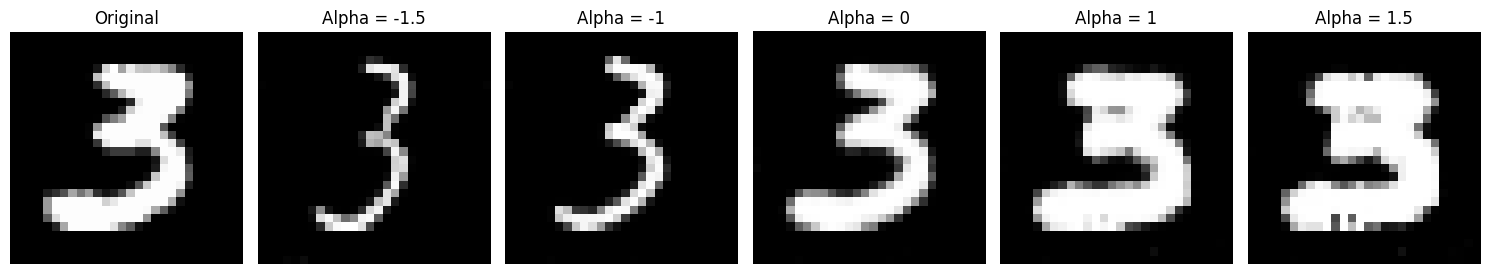

In [126]:
# Select a sample and find its latent vector
real_sample,_ = next(iter(train_loader))
real_sample = real_sample[0]
lat_vector = find_latent_vector(generator, real_sample, latent_dim=config["model_params"]["latent_dim"])

# Modify the attribute
alpha_values = [-1.5, -1, 0, 1, 1.5]  #
modified_samples = [
    modify_attribute(generator, lat_vector, direction, alpha)
    for alpha in alpha_values
]

# Plot the original and modified samples
fig, axs = plt.subplots(1, len(alpha_values) + 1, figsize=(15, 5))
axs[0].imshow(real_sample.squeeze().cpu().numpy(), cmap="gray")
axs[0].set_title("Original")
axs[0].axis("off")

for i, modified_sample in enumerate(modified_samples):
    axs[i + 1].imshow(modified_sample.cpu().numpy().squeeze(), cmap="gray")
    axs[i + 1].set_title(f"Alpha = {alpha_values[i]}")
    axs[i + 1].axis("off")

plt.tight_layout()
plt.show()

In [155]:
all_samples = []
all_labels = []
for images, labels in train_loader:
    all_samples.append(images)
    all_labels.append(labels)

all_samples = torch.cat(all_samples)
all_labels = torch.cat(all_labels)

# Fetch target samples (e.g., "3")
target_samples = all_samples[all_labels == 3]

# Initialize a list to store transformation directions for each source digit
digit_directions = []

# Compute transformation directions for all source digits (0-9 except 3)
for source_digit in range(10):
    if source_digit == 3:
        continue

    source_samples = all_samples[all_labels == source_digit]

    direction = identify_direction(
        generator,
        target_samples=target_samples[:20],
        source_samples=source_samples[:20],
        latent_dim=config["model_params"]["latent_dim"]
    )

    digit_directions.append((source_digit, direction))

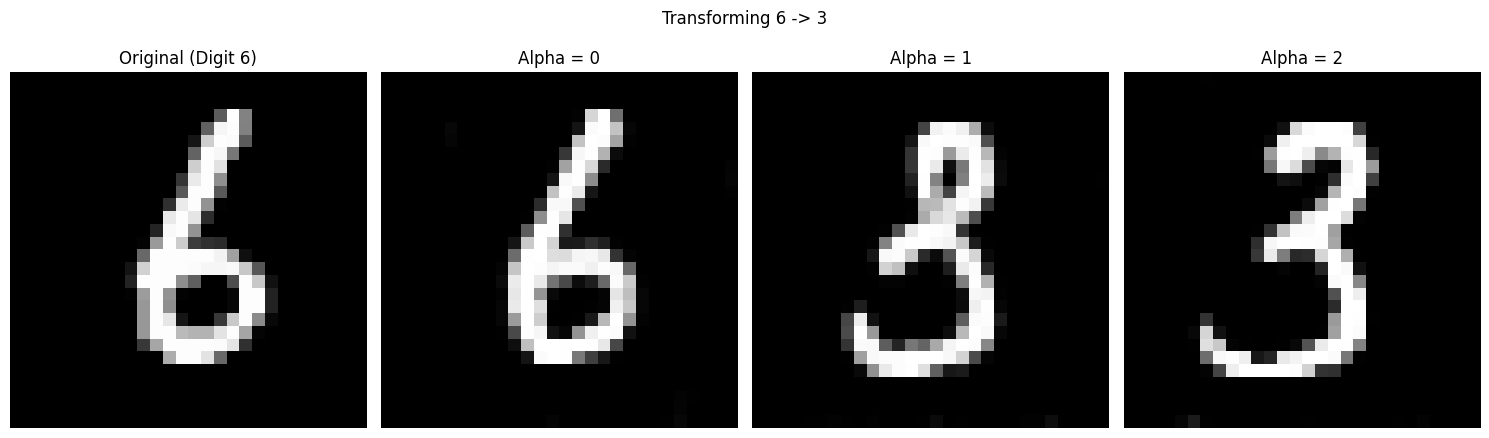

In [169]:
source_sample , source_digit = next(iter(train_loader))
source_sample = source_sample[0]
source_digit = source_digit[0]
source_sample = source_sample.unsqueeze(0)

# Find the appropriate direction for the source digit
for digit, direction in digit_directions:
    if digit == source_digit:
        selected_direction = direction
        break

# Discover the latent vector for the selected sample
latent_vector = find_latent_vector(generator, source_sample, latent_dim=config["model_params"]["latent_dim"])

# Transform the digit into the target digit
alpha_values = [0, 1, 2]
transformed_samples = [
    modify_attribute(generator, latent_vector, selected_direction, alpha)
    for alpha in alpha_values
]

# Plot the original and transformed digits
fig, axs = plt.subplots(1, len(alpha_values) + 1, figsize=(15, 5))
axs[0].imshow(source_sample.squeeze().cpu().numpy(), cmap="gray")
axs[0].set_title(f"Original (Digit {source_digit})")
axs[0].axis("off")

for i, transformed_sample in enumerate(transformed_samples):
    axs[i + 1].imshow(transformed_sample.cpu().numpy().squeeze(), cmap="gray")
    axs[i + 1].set_title(f"Alpha = {alpha_values[i]}")
    axs[i + 1].axis("off")

plt.tight_layout()
plt.suptitle(f"Transforming {source_digit} -> 3")
plt.show()

In [170]:
generator_path = "generator.pth"
discriminator_path = "discriminator.pth"

# Save the generator
torch.save(generator.state_dict(), generator_path)
print(f"Generator model saved to {generator_path}")

# Save the discriminator
torch.save(discriminator.state_dict(), discriminator_path)
print(f"Discriminator model saved to {discriminator_path}")

Generator model saved to generator.pth
Discriminator model saved to discriminator.pth
